# Exercise 5: Restricted Boltzmann Machines

## Group nickname: ```MuonGang```

### Participants:

| Name               | Id          |
| :---------------   | :--------   |
| Ardino Rocco       | **1231629** |
| Paccagnella Andrea | **1211171** |
| Valente Alessandro | **1234429** |

# Index <a class="anchor" id="Ex5.i"></a>

* 0. [Code from video lessons](#Ex5.0.)<br>
    * 0.1. [Data definition](#Ex5.0.1.)<br>
    * 0.2. [Data generation](#Ex5.0.2.)<br>
    * 0.3. [Data storage](#Ex5.0.3.)<br>
    * 0.4. [Restricted Boltzmann Machine: example](#Ex5.0.4.)<br>
        * 0.4.1. [Read data](#Ex5.0.4.1.)<br>
        * 0.4.2. [Convert data to +1/-1 (spins)](#Ex5.0.4.2.)<br>
        * 0.4.3. [Initialize arrays and parameters](#Ex5.0.4.3.)<br>
        * 0.4.4. [Functions for plotting](#Ex5.0.4.4.)<br>
        * 0.4.5. [Sigmoid function and activation](#Ex5.0.4.5.)<br>
        * 0.4.6. [RBM train](#Ex5.0.4.6.)<br>
        * 0.4.7. [Denoising](#Ex5.0.4.7.)<br>
* 1. [Lower temperature for the activation](#Ex5.1.)<br>
    * 1.1. [```activate``` function](#Ex5.1.1.)<br>
    * 1.2. [```train_RBM``` function](#Ex5.1.2.)<br>
    * 1.3. [```gen_data``` function](#Ex5.1.3.)<br>
    * 1.4. [```evaluateC``` function](#Ex5.1.4.)<br>
* 2. [Performance evaluation](#Ex5.2.)<br>
    * 2.1. [Performance with lower temperature](#Ex5.2.1.)<br>
    * 2.2. [Deterministic case](#Ex5.2.2.)<br>
    * 2.3. [Minimum ```inv_T``` for perfect score](#Ex5.2.3.)<br>
* 3. [Test with additional states](#Ex5.3.)<br>
    * 3.1. [5 cases ($C=5$)](#Ex5.3.1.)<br>
    * 3.2. [6 cases ($C=6$)](#Ex5.3.2.)<br>
    * 3.3. [Tests for $M\ge1$](#Ex5.3.3.)<br>
* 4. [Experiments](#Ex5.4.)<br>
    * 4.1. [4 cases ($C=4$)](#Ex5.4.1.)<br>
    * 4.2. [5 cases ($C=5$)](#Ex5.4.2.)<br>
    * 4.3. [6 cases ($C=6$)](#Ex5.4.3.)<br>

# 0. - Code from video lessons <a class="anchor" id="Ex5.0."></a>
* [Index](#Ex5.i)

In [1]:
import random
import csv 
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline

## 0.1. - Data definition <a class="anchor" id="Ex5.0.1."></a>
* [Index](#Ex5.i)

In [2]:
# number of data
N = 10000
# possible different cases
C = 4
# block size
Z = 2
# size of each data point
L = C*Z
# choose mong states
# (1010), (0110), (1001), (0101)
# from a 2x2 product of (1,0)x(1,0)
# with prob=1/4
# switch each variable of the L ones with probability q
q = 0.1

y = [0] * N
x = [[0] * L for j in range(N)]
v0 = [0] * Z
v1 = [1] * Z
case = (v1 + v0 + v1 + v0,
        v0 + v1 + v1 + v0,
        v1 + v0 + v0 + v1,
        v0 + v1 + v0 + v1)
print('------------- 4 cases')
for c in range(C):
    print('"',c,'"  ',*case[c], sep="")

------------- 4 cases
"0"  11001100
"1"  00111100
"2"  11000011
"3"  00110011


## 0.2. - Data generation <a class="anchor" id="Ex5.0.2."></a>
* [Index](#Ex5.i)

In [3]:
random.seed(12345)

for i in range(N):
    y[i] = random.randint(0,3)
    x[i][:] = case[y[i]]
    for j in range(L):
        if random.random() < 0.1:
            x[i][j] = 1 - x[i][j]

print('------------- DATA')
for i in range(10):
    print('"',y[i],'"  ',*x[i], sep="")
print('...')

------------- DATA
"3"  00110011
"3"  00110011
"1"  00110100
"3"  10110111
"1"  00111100
"1"  00111100
"2"  11000010
"3"  10110011
"3"  01110011
"0"  10001100
...


## 0.3. - Data storage <a class="anchor" id="Ex5.0.3."></a>
* [Index](#Ex5.i)

In [4]:
fname = 'dataRBM_q' + str(q) + '.csv'
print(fname)

with open(fname, mode='w') as myfile:
    writer = csv.writer(myfile, delimiter=',')
    for i in range(N):
        writer.writerow(x[i])

dataRBM_q0.1.csv


## 0.4. - Restricted Boltzmann Machine: example <a class="anchor" id="Ex5.0.4."></a>
* [Index](#Ex5.i)

### 0.4.1. - Read data <a class="anchor" id="Ex5.0.4.1."></a>

In [5]:
fname = 'dataRBM_q0.1.csv'
# loading data: each row is a list of visible units
data = np.loadtxt(fname, delimiter=',', dtype=int)
# to start, take a small subsample
# v = v[0:10]
N = len(data)
L = len(data[1])
print(f'each of N={N} data has L={L} digits')

each of N=10000 data has L=8 digits


### 0.4.2. - Convert data to +1/-1 (spins) <a class="anchor" id="Ex5.0.4.2."></a>

In [6]:
# convert 0,1 -> -1,+1 (spin system)
v = 2*data - 1
# store in v0 because later we will shuffle v
v0 = np.zeros_like(v)
v0[:] = v[:]

for k in range(10):
    print(data[k], v[k])
print('...')

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 1 0 0] [-1 -1  1  1 -1  1 -1 -1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[1 1 0 0 0 0 1 0] [ 1  1 -1 -1 -1 -1  1 -1]
[1 0 1 1 0 0 1 1] [ 1 -1  1  1 -1 -1  1  1]
[0 1 1 1 0 0 1 1] [-1  1  1  1 -1 -1  1  1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]
...


### 0.4.3. - Initialize arrays and parameters <a class="anchor" id="Ex5.0.4.3."></a>

In [7]:
np.random.seed(12342)

# RBM, number of hidden units
M = 2
# range of each initial weight
sigma = np.sqrt(4. / float(L+M))
# initial weights (see literature, e.g. page 98, but here not Gaussian)
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L)   - 1)
b = np.zeros(M)
print(w)
print(a)
print(b)
# store initial weights
w0, a0, b0 = w, a, b

[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
[0. 0.]


### 0.4.4. - Functions for plotting <a class="anchor" id="Ex5.0.4.4."></a>

[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


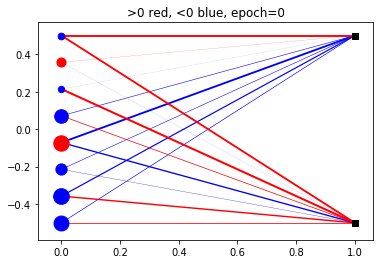

In [8]:
# line-up layers vertically
def create_coord(np, x0):
    x = [x0] * np
    print(x)
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5
    return (x,y)
(x1, y1) = create_coord(L,0)
(x2, y2) = create_coord(M,1)

# choose color according to sign
def mycolor(val):
    if val > 0:
        return 'red'
    elif val < 0:
        return 'blue'
    return 'black'

def plotgraph(epoch=0, M=2):
    # zorder -> scatter plot of dots on top of lines
    # A: make max line width = 2
    A = 2. / w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
        
    
    # PS: scale of the point size
    PS    = 400.
    PSmin =  40
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=max(PSmin, PS*np.abs(a[i])), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=max(PSmin, PS*np.abs(b[j])), zorder=2, c=mycolor(b[j]), marker='s')
    
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()

plotgraph()

### 0.4.5. - Sigmoid function and activation <a class="anchor" id="Ex5.0.4.5."></a>

In [9]:
# eq(213) page 97
# activation via sigmoid
def activate(v_in, wei, bias, inv_T=1, info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + exp(-inv_T*act))
    n = np.shape(act)
    # a list on 1's
    v_out = - np.ones(n, dtype=int)
    # activate the 1's with probability prob
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input  =', v_in )
        print('act    =', act  )
        print('prob   =', prob )
        print('output =', v_out)
    return v_out

k = 0
activate(v[k], w, b, info=True)

input  = [-1 -1  1  1 -1 -1  1  1]
act    = [-1.4184683   0.61989888]
prob   = [0.19490182 0.65019555]
output = [-1  1]


array([-1,  1])

### 0.4.6. - RBM train <a class="anchor" id="Ex5.0.4.6."></a>

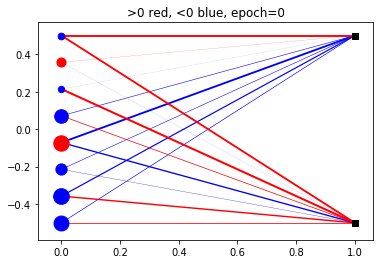

------------- epoch = 1   k= 499   m= 500
dw = [[ 0.12   0.036]
 [ 0.192  0.036]
 [-0.164 -0.248]
 [-0.348 -0.152]
 [-0.112 -0.132]
 [ 0.132  0.248]
 [-0.144 -0.012]
 [ 0.328  0.244]]
da = [-0.176 -0.16   0.116 -0.284 -0.064  0.092  0.248 -0.232]
db = [ 0.008 -0.036]
completed epoch 1 with l_rate = 1.0
------------- epoch = 2   k= 499   m= 500
dw = [[-0.05666667  0.01333333]
 [ 0.01        0.        ]
 [ 0.01666667  0.02666667]
 [ 0.02        0.03666667]
 [-0.08        0.11666667]
 [-0.05333333  0.10333333]
 [ 0.07333333 -0.08333333]
 [ 0.06666667 -0.13666667]]
da = [ 0.00666667 -0.02666667 -0.02666667  0.04333333  0.00333333  0.01
  0.10333333  0.01      ]
db = [-0.03       -0.02666667]
completed epoch 2 with l_rate = 0.8333333333333334
completed epoch 3 with l_rate = 0.7142857142857143
completed epoch 4 with l_rate = 0.625
completed epoch 5 with l_rate = 0.5555555555555556


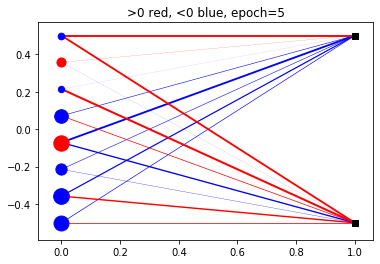

completed epoch 6 with l_rate = 0.5
completed epoch 7 with l_rate = 0.45454545454545453
completed epoch 8 with l_rate = 0.4166666666666667
completed epoch 9 with l_rate = 0.38461538461538464
completed epoch 10 with l_rate = 0.3571428571428572


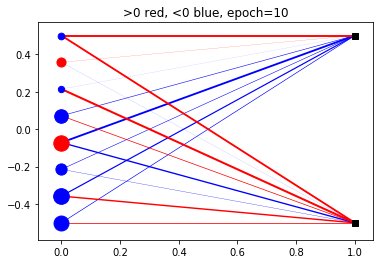

completed epoch 11 with l_rate = 0.3333333333333334
completed epoch 12 with l_rate = 0.3125000000000001
completed epoch 13 with l_rate = 0.29411764705882365
completed epoch 14 with l_rate = 0.2777777777777779
completed epoch 15 with l_rate = 0.2631578947368422


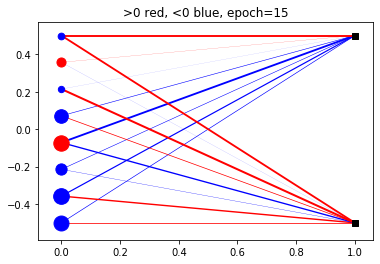

completed epoch 16 with l_rate = 0.2500000000000001
completed epoch 17 with l_rate = 0.2380952380952382
completed epoch 18 with l_rate = 0.22727272727272735
completed epoch 19 with l_rate = 0.21739130434782616
completed epoch 20 with l_rate = 0.20833333333333343


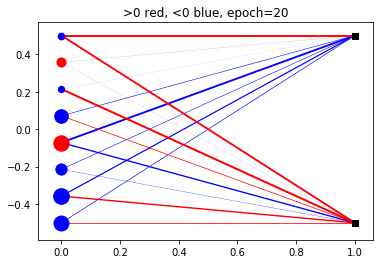

completed epoch 20 with l_rate = 0.20000000000000007


In [10]:
plotgraph(0)

# learning rate
l_rate = 1.0

# minibatch size (mini) and index (m=0,...,mini-1)
mini, m = 500, 0
# number of epochs
max_epoch = 20

# train model
def train_RBM(v, max_epoch=20, l_rate=1.0, mini=500, m=0, inv_T=1, patience=5, verbose=True, grid=False):
    # global L, M, sigma, w, a, b
    L = len(v[1])
    # number of hidden units
    M = 2
    
    # range of each initial weight
    sigma = np.sqrt(4. / float(L+M))
    # initial weights (see literature, e.g. page 98, but here not Gaussian)
    w = sigma * (2*np.random.rand(L,M) - 1)
    a = sigma * (2*np.random.rand(L)   - 1)
    b = np.zeros(M)
    
    for epoch in range(1, 1+max_epoch):
        l_rate_m = l_rate / mini
        for k in range(N):
            if m==0:
                # initialize averages in miniblock
                v_data , v_model  = np.zeros(L)    , np.zeros(L)
                h_data , h_model  = np.zeros(M)    , np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))

            # positive CD phase: generating h
            h  = activate(v[k], w, b, inv_T=inv_T)
            # negative CD phase: generating fantasy vf
            vf = activate(h, w.T, a, inv_T=inv_T)
            # one more positive CD phase: generating fantasy h from fantasy vf
            hf = activate(vf, w, b, inv_T=inv_T)

            v_data   += v[k]
            v_model  += vf
            h_data   += h
            h_model  += hf
            vh_data  += np.outer(v[k].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            # minibatch
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # vanilla gradient descent method
                dw = l_rate_m * (vh_data - vh_model)
                da = l_rate_m * (v_data  - v_model)
                db = l_rate_m * (h_data  - h_model)
                if epoch <= 2 and k <= mini and verbose:
                    print('------------- epoch =', epoch, '  k=', k, '  m=', m)
                    print('dw =', dw)
                    print('da =', da)
                    print('db =', db)
                # basic step of vanilla gradient descent, from eq. (211)
                w = w + dw
                a = a + da
                b = b + db
                m = 0

        if verbose: print('completed epoch', epoch, 'with l_rate =', l_rate)

        # randomize the order of input data
        np.random.shuffle(v)
        # let the learning rate decay as epoch^-1
        l_rate = l_rate / (0.2*l_rate + 1)
        if (epoch%patience==0) and verbose:
            plotgraph(epoch)

    if not grid:
        print('completed epoch', max_epoch, 'with l_rate =', l_rate)
    
    return w, a, b

# train on data and return w, a, b
w, a, b = train_RBM(v)

In [11]:
print('w0 =', w0)
print('w  =', w )
print('a0 =', a0)
print('a  =', a )
print('b0 =', b0)
print('b  =', b )

w0 = [[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
w  = [[ 2.16711991 -0.06578442]
 [ 2.22186969 -0.02343887]
 [-2.21518884  0.05777761]
 [-2.18397293  0.09894517]
 [ 0.02322653  2.2009658 ]
 [ 0.11419311  2.22384118]
 [ 0.01262902 -2.15706657]
 [-0.10347498 -2.20415978]]
a0 = [-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
a  = [-0.08846952  0.00520991  0.02444142 -0.05403609  0.03456107 -0.00208157
  0.02769269  0.03203681]
b0 = [0. 0.]
b  = [ 0.0414369  -0.02205957]


### 0.4.7. - Denoising <a class="anchor" id="Ex5.0.4.7."></a>

In [12]:
def evaluate(v0, w, a, b, N=N, M=M, L=L, mini=mini, fname=fname, inv_T=1):
    # original, non-reshuffled data in v0
    v1 = np.zeros_like(v0)
    for k in range(N):
        # positive CD phase: generating h
        h = activate(v0[k], w, b, inv_T=inv_T)
        # negative CD phase: generating fantasy vf
        v1[k] = activate(h, w.T, a, inv_T=inv_T)

    # difference between fantasy and data
    diff = (v1 - v0) / 2
    str0 = 'M' + str(M) + '-mini' + str(mini) + fname
    np.savetxt('fant-' + str0, (v1+1)/2, fmt='%d', delimiter=',')
    np.savetxt('diff-' + str0, diff    , fmt='%d', delimiter=',')

    Z = int(L/4)
    vv0 = [0] * Z
    vv1 = [1] * Z
    case = (vv1 + vv0 + vv1 + vv0,
            vv0 + vv1 + vv1 + vv0,
            vv1 + vv0 + vv0 + vv1,
            vv0 + vv1 + vv0 + vv1)

    for k in range(10):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        print(vec0, vec1, (is0 or is1 or is2 or is3))
    print('...')
    
    counts = 0
    for k in range(N):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        if (is0 or is1 or is2 or is3):
            counts += 1
    
    return counts/N

In [13]:
score = evaluate(v0, w, a, b)
print(score)

[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 0] False
[0 0 1 1 0 0 1 1] [1 0 1 1 0 0 1 1] False
[0 0 1 1 0 1 0 0] [0 1 1 1 1 0 0 0] False
[1 0 1 1 0 1 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 1 1 0 0] [0 0 0 1 0 1 0 0] False
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0] True
[1 1 0 0 0 0 1 0] [1 0 0 0 0 0 1 1] False
[1 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 0] False
[0 1 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 0 0 0] False
...
0.4228


# 1. - Lower temperature for the activation <a class="anchor" id="Ex5.1."></a>
* [Index](#Ex5.i)

The first step we make is redefining the functions that represent the activation and the training of our RBM, in the specific:

- the ```activate``` function is the same of the previuos one from video lessons, but we added another argument, namely ```inv_T```, which represents the inverse of the temperature.<br>
- The ```train_RBM``` function receive as input the data and train the RBM returing its parameters so that we can evaluate the performance on them.<br>
- The ```gen_data``` function generates the data as we saw in the example from video lessons, but can generate with various numbers of cases (```C``` up to 6) and with different values of ```Z``` (which modifies the lenght of each data).<br>
- The ```evaluateC``` function is used to determinate the score computed as the fraction of cases that the machine is able to denoise after the random corruption.<br>

In [14]:
N = 10000
C = 4
Z = 2
L = C*Z
M = 2 
q = 0.1

## 1.1. - ```activate``` function <a class="anchor" id="Ex5.1.1."></a>
* [Index](#Ex5.i)

In [15]:
def activate(v_in, wei, bias, inv_T=1, info=False):
    act  = np.dot(v_in, wei) + bias
    prob = 1. / (1. + exp(-inv_T*act))
    n    = np.shape(act)
    
    # a list on 1's
    v_out = - np.ones(n, dtype=int)
    
    # activate the 1's with probability prob
    v_out[np.random.random_sample(n) < prob] = 1
    
    if info:
        print('input  =', v_in )
        print('act    =', act  )
        print('prob   =', prob )
        print('output =', v_out)
    
    return v_out

## 1.2. - ```train_RBM``` function <a class="anchor" id="Ex5.1.2."></a>
* [Index](#Ex5.i)

In [16]:
# learning rate
l_rate = 1.0

# minibatch size (mini) and index (m=0,...,mini-1)
mini, m = 500, 0

# number of epochs
max_epoch = 20

# train model
def train_RBM(v, max_epoch=20, l_rate=1.0, mini=500, m=0, inv_T=1, patience=5, verbose=True, grid=False, M=2):
    # global L, M, sigma, w, a, b
    L = len(v[1])
    
    # range of each initial weight
    sigma = np.sqrt(4. / float(L+M))
    
    # initial weights (see literature, e.g. page 98, but here not Gaussian)
    w = sigma * (2*np.random.rand(L,M) - 1)
    a = sigma * (2*np.random.rand(L)   - 1)
    b = np.zeros(M)
    
    for epoch in range(1, 1+max_epoch):
        l_rate_m = l_rate / mini
        for k in range(N):
            if m==0:
                # initialize averages in miniblock
                v_data , v_model  = np.zeros(L)    , np.zeros(L)
                h_data , h_model  = np.zeros(M)    , np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))

            # positive CD phase: generating h
            h  = activate(v[k], w, b, inv_T=inv_T)
            # negative CD phase: generating fantasy vf
            vf = activate(h, w.T, a, inv_T=inv_T)
            # one more positive CD phase: generating fantasy h from fantasy vf
            hf = activate(vf, w, b, inv_T=inv_T)

            v_data   += v[k]
            v_model  += vf
            h_data   += h
            h_model  += hf
            vh_data  += np.outer(v[k].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            # minibatch
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # vanilla gradient descent method
                dw = l_rate_m * (vh_data - vh_model)
                da = l_rate_m * (v_data  - v_model)
                db = l_rate_m * (h_data  - h_model)
                if epoch <= 2 and k <= mini and verbose:
                    print('------------- epoch =', epoch, '  k=', k, '  m=', m)
                    print('dw =', dw)
                    print('da =', da)
                    print('db =', db)
                # basic step of vanilla gradient descent, from eq. (211)
                w = w + dw
                a = a + da
                b = b + db
                m = 0

        if verbose: print('completed epoch', epoch, 'with l_rate =', l_rate)

        # randomize the order of input data
        np.random.shuffle(v)
        
        # let the learning rate decay as epoch^-1
        l_rate = l_rate / (0.2*l_rate + 1)
        if (epoch%patience==0) and verbose:
            plotgraph(w, epoch, M)

    if not grid:
        print('completed epoch', max_epoch, 'with l_rate =', l_rate)
    
    return w, a, b

def plotgraph(w, epoch=0, M=2):
    # zorder -> scatter plot of dots on top of lines
    # A: make max line width = 2
    A = 2. / w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i], x2[j]), (y1[i], y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
        
    
    # PS: scale of the point size
    PS    = 400.
    PSmin =  40
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=max(PSmin, PS*np.abs(a[i])), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=max(PSmin, PS*np.abs(b[j])), zorder=2, c=mycolor(b[j]), marker='s')
    
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()



## 1.3. - ```gen_data``` function <a class="anchor" id="Ex5.1.3."></a>
* [Index](#Ex5.i)

In [17]:
def gen_data(N=10000, C=4, Z=2, q=0.1, verbose=True):
    random.seed(12345)
    L = 4*Z
    y = [0] * N
    x = [[0] * L for j in range(N)]
    
    v0 = [0] * Z
    v1 = [1] * Z
    v2 = [1] + [0] * (Z-1)
    
    case = (v1 + v0 + v1 + v0,
            v0 + v1 + v1 + v0,
            v1 + v0 + v0 + v1,
            v0 + v1 + v0 + v1,
            v1 + v1 + v1 + v1,
            v2 + v2 + v2 + v0)
    
    for i in range(N):
        y[i] = random.randint(0,C-1)
        x[i][:] = case[y[i]]
        for j in range(L):
            if random.random() < q:
                x[i][j] = 1 - x[i][j]
    
    if verbose:
        print('------------- '+str(C)+' cases')
        for c in range(C):
            print('"',c,'"  ',*case[c], sep="") 
        print('------------- DATA')
        for i in range(10):
            print('"',y[i],'"  ',*x[i], sep="")
        print('...')
     
    fname = 'dataRBM_q' + str(q) + '_C' + str(C) + '.csv'
    with open(fname, mode='w') as myfile:
        writer = csv.writer(myfile, delimiter=',')
        for i in range(N):
            writer.writerow(x[i])
    
    data  = np.loadtxt(fname, delimiter=',', dtype=int)  
    v     = 2*data - 1
    v0    = np.zeros_like(v)
    v0[:] = v[:]
    
    if verbose:
        for k in range(10):
            print(data[k], v[k])
        print('...')
    
    return v0, v, fname

## 1.4. - ```evaluateC``` function <a class="anchor" id="Ex5.1.4."></a>
* [Index](#Ex5.i)

In [18]:
def evaluateC(v0, w, a, b, C=4, M=2, Z=2, mini=mini, fname='', inv_T=1, verbose=True):
    N  = len(v0)
    L  = len(v0[1])
    v1 = np.zeros_like(v0)
    
    for k in range(N):
        # positive CD phase: generating h
        h = activate(v0[k], w, b, inv_T=inv_T)
        # negative CD phase: generating fantasy vf
        v1[k] = activate(h, w.T, a, inv_T=inv_T)

    # difference between fantasy and data
    diff = (v1 - v0) / 2
    str0 = 'M' + str(M) + '-mini' + str(mini) + fname
    np.savetxt('fant-' + str0, (v1+1)/2, fmt='%d', delimiter=',')
    np.savetxt('diff-' + str0, diff    , fmt='%d', delimiter=',')

    Z = int(L/4)
    vv0 = [0] * Z
    vv1 = [1] * Z
    vv2 = [1] + [0] * (Z-1)
    case = (vv1 + vv0 + vv1 + vv0,
            vv0 + vv1 + vv1 + vv0,
            vv1 + vv0 + vv0 + vv1,
            vv0 + vv1 + vv0 + vv1,
            vv1 + vv1 + vv1 + vv1,
            vv2 + vv2 + vv2 + vv0)
    
    if verbose:
        for k in range(10):
            vec0 = ((v0[k]+1)/2).astype(int)
            vec1 = ((v1[k]+1)/2).astype(int)
            isTrue = False
            for c in range(C):
                isTrue = isTrue or (vec1==case[c]).all()
            print(vec0, vec1, isTrue)
        print('...')
    
    counts = 0
    for k in range(N):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        isTrue = False
        for c in range(C):
            isTrue= isTrue or (vec1==case[c]).all()
        if (isTrue):
            counts += 1
    
    return counts/N

# 2. - Performance evaluation <a class="anchor" id="Ex5.2."></a>
* [Index](#Ex5.i)

The first thing we will do is using these functions to reproduce the results we from video lessons.

------------- 4 cases
"0"  11001100
"1"  00111100
"2"  11000011
"3"  00110011
------------- DATA
"3"  00110011
"3"  00110011
"1"  00110100
"3"  10110111
"1"  00111100
"1"  00111100
"2"  11000010
"3"  10110011
"3"  01110011
"0"  10001100
...
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 1 0 0] [-1 -1  1  1 -1  1 -1 -1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[1 1 0 0 0 0 1 0] [ 1  1 -1 -1 -1 -1  1 -1]
[1 0 1 1 0 0 1 1] [ 1 -1  1  1 -1 -1  1  1]
[0 1 1 1 0 0 1 1] [-1  1  1  1 -1 -1  1  1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]
...
------------- epoch = 1   k= 499   m= 500
dw = [[-0.212 -0.072]
 [ 0.236 -0.256]
 [ 0.048 -0.14 ]
 [-0.016 -0.012]
 [ 0.212 -0.28 ]
 [ 0.196 -0.264]
 [-0.328  0.356]
 [-0.264  0.3  ]]
da = [-0.088 -0.336 -0.156 -0.044  0.232  0.264  0.004  0.1  ]
db = [ 0.148 -0.208]
completed epoch 1 with l_rate = 1.0
-----------

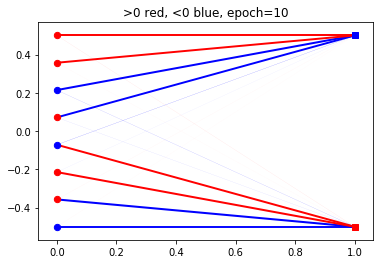

completed epoch 11 with l_rate = 0.3333333333333334
completed epoch 12 with l_rate = 0.3125000000000001
completed epoch 13 with l_rate = 0.29411764705882365
completed epoch 14 with l_rate = 0.2777777777777779
completed epoch 15 with l_rate = 0.2631578947368422
completed epoch 16 with l_rate = 0.2500000000000001
completed epoch 17 with l_rate = 0.2380952380952382
completed epoch 18 with l_rate = 0.22727272727272735
completed epoch 19 with l_rate = 0.21739130434782616
completed epoch 20 with l_rate = 0.20833333333333343


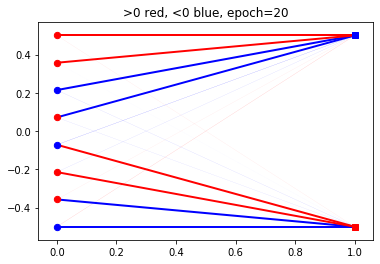

completed epoch 21 with l_rate = 0.20000000000000007
completed epoch 22 with l_rate = 0.19230769230769237
completed epoch 23 with l_rate = 0.18518518518518523
completed epoch 24 with l_rate = 0.17857142857142863
completed epoch 25 with l_rate = 0.17241379310344832
completed epoch 26 with l_rate = 0.16666666666666669
completed epoch 27 with l_rate = 0.16129032258064516
completed epoch 28 with l_rate = 0.15625
completed epoch 29 with l_rate = 0.15151515151515152
completed epoch 30 with l_rate = 0.14705882352941177


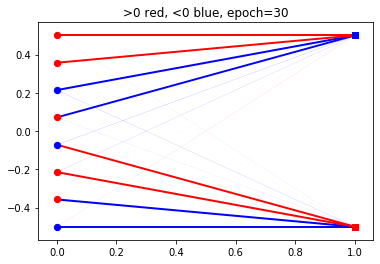

completed epoch 30 with l_rate = 0.14285714285714288
[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 0 0 1 1] [0 0 1 0 0 0 1 1] False
[0 0 1 1 0 1 0 0] [0 0 1 1 1 1 0 0] True
[1 0 1 1 0 1 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 1] False
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0] True
[1 1 0 0 0 0 1 0] [1 1 0 0 0 0 1 1] True
[1 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 1 1 1 0 0 1 1] [1 0 1 1 0 0 1 1] False
[1 0 0 0 1 1 0 0] [1 1 0 0 1 1 0 0] True
...
0.423


In [19]:
v0, v, fname = gen_data()
w, a, b      = train_RBM(v, max_epoch=30, inv_T=1, verbose=True, patience=10)
score        = evaluateC(v0, w, a, b, inv_T=1)
print(score)

## 2.1. - Performance with lower temperature <a class="anchor" id="Ex5.2.1."></a>
* [Index](#Ex5.i)

Now that we have already generated the parameters we can try to change ```inv_T``` to see if we can improve the score.

In [20]:
score = evaluateC(v0, w, a, b, inv_T=2)
print(score)

[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 0 1 0 0] [0 0 1 1 1 1 0 0] True
[1 0 1 1 0 1 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 1 1 0 0] [0 1 1 1 1 1 0 0] False
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0] True
[1 1 0 0 0 0 1 0] [1 1 0 0 0 0 1 1] True
[1 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 1 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 1 0 0] True
...
0.901


## 2.2. - Deterministic case <a class="anchor" id="Ex5.2.2."></a>
* [Index](#Ex5.i)

In [21]:
score = evaluateC(v0, w, a, b, inv_T=np.inf)
print(score)

[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 0 1 0 0] [0 0 1 1 1 1 0 0] True
[1 0 1 1 0 1 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0] True
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0] True
[1 1 0 0 0 0 1 0] [1 1 0 0 0 0 1 1] True
[1 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 1 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 1 0 0] True
...
1.0


As we can see the score improves fastly by decreasing the temperature and in case of $T=0$, which is represented by its inverse going to infinity, the score is 1.

## 2.3. - Minimum ```inv_T``` for perfect score <a class="anchor" id="Ex5.2.3."></a>
* [Index](#Ex5.i)

We already saw that the machine in the deterministic case is able to obtain a perfect score, what we can do is then try to see at which temperature the score is perfect while still remaining in the stochastic regime.

Inverse temperature:  0.1  --> Score:  0.0241
Inverse temperature:  0.5  --> Score:  0.0984
Inverse temperature:  1  --> Score:  0.4123
Inverse temperature:  2  --> Score:  0.8954
Inverse temperature:  3  --> Score:  0.9887
Inverse temperature:  5  --> Score:  1.0
Inverse temperature:  10  --> Score:  1.0
Inverse temperature:  15  --> Score:  1.0
Inverse temperature:  20  --> Score:  1.0


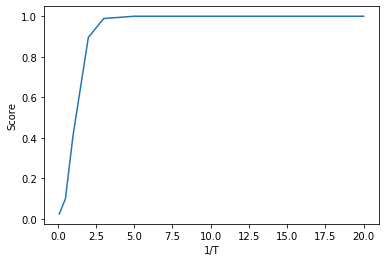

In [22]:
invs   = [1e-1, 5e-1, 1, 2, 3, 5, 10, 15, 20]
scores = []

for inv_T in invs:
    score = evaluateC(v0, w, a, b, inv_T=inv_T, C=5, fname=fname, verbose=False)
    scores.append(score)
    print("Inverse temperature: ", inv_T, " --> Score: ", score)

plt.plot(invs, scores)
plt.xlabel("1/T")
plt.ylabel("Score")
plt.show()

As we can see, for this situation the score goes very quickly to 1 for $T=0.2$ ($\frac{1}{T}=5$) so the machine is still able to perfectly restore the data even without a deterministic activation function.

# 3. - Test with additional states <a class="anchor" id="Ex5.3."></a>
* [Index](#Ex5.i)

We define 2 new states and try to see how the previous result changes in these situations.
We will not show all the informations about training and data generation, but those can be obtained by setting in the functions ```verbose=True``` while running.

## 3.1. - 5 cases ($C=5$) <a class="anchor" id="Ex5.3.1."></a>
* [Index](#Ex5.i)

We define now a fifth state: ```4 := 11111111``` and try to do the same thing as before, the new state is generated by passing $C=5$ to the function.

In [23]:
v0,v, fname = gen_data(C=5, verbose=False)
w, a, b     = train_RBM(v, max_epoch=30, inv_T=1, verbose=False, patience=10)
score       = evaluateC(v0, w, a, b, inv_T=2, C=5, fname=fname)
print(score)

completed epoch 30 with l_rate = 0.14285714285714288
[0 0 1 1 0 0 1 1] [0 0 0 1 0 0 1 1] False
[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[1 1 1 1 1 0 1 1] [1 1 0 0 0 0 1 1] True
[1 0 1 1 0 1 1 1] [0 0 1 1 0 1 1 1] False
[1 1 1 1 1 1 0 1] [0 1 0 0 1 1 0 1] False
[0 0 1 1 0 0 1 0] [0 0 1 1 0 0 1 1] True
[0 0 0 1 1 1 0 1] [0 0 1 1 1 1 0 0] True
[1 0 0 0 1 1 0 0] [1 1 0 1 1 1 0 0] False
[1 0 0 0 1 1 0 0] [1 1 0 0 1 1 0 0] True
[1 0 0 0 1 1 0 0] [1 1 1 0 1 1 0 0] False
...
0.5703


We can see that with an additional case the RBM does not properly denoise the data. Firstly, we'll analyze how the machine works in the deterministic case, then we will try (as before) to find which is the temperature needed for the machine to obtain a perfect score.

In [24]:
score = evaluateC(v0, w, a, b, inv_T=np.inf, C=5, fname=fname)
print(score)

[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[1 1 1 1 1 0 1 1] [1 1 0 0 0 0 1 1] True
[1 0 1 1 0 1 1 1] [0 0 1 1 0 0 1 1] True
[1 1 1 1 1 1 0 1] [1 1 0 0 1 1 0 0] True
[0 0 1 1 0 0 1 0] [0 0 1 1 0 0 1 1] True
[0 0 0 1 1 1 0 1] [0 0 1 1 1 1 0 0] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 1 0 0] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 1 0 0] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 1 0 0] True
...
1.0


The deterministic case has a perfect score as expected, we can then try to do a plot as we did before to see how the score changes depending on the temperature :

Inverse temperature:  0.1  --> Score:  0.0245
Inverse temperature:  0.5  --> Score:  0.0694
Inverse temperature:  1  --> Score:  0.242
Inverse temperature:  2  --> Score:  0.564
Inverse temperature:  3  --> Score:  0.7011
Inverse temperature:  5  --> Score:  0.8029
Inverse temperature:  10  --> Score:  0.9379
Inverse temperature:  15  --> Score:  0.9848
Inverse temperature:  20  --> Score:  0.9965
Inverse temperature:  25  --> Score:  0.9996
Inverse temperature:  30  --> Score:  0.9998
Inverse temperature:  40  --> Score:  1.0
Inverse temperature:  50  --> Score:  1.0


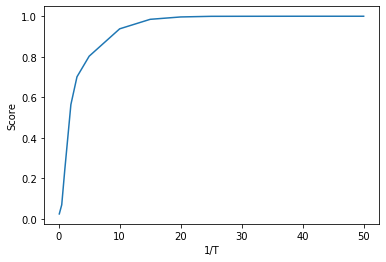

In [25]:
invs   = [1e-1, 5e-1, 1, 2, 3, 5, 10, 15, 20, 25, 30, 40, 50]
scores = []

for inv_T in invs:
    score = evaluateC(v0, w, a, b, inv_T=inv_T, C=5, fname=fname, verbose=False)
    scores.append(score)
    print("Inverse temperature: ", inv_T, " --> Score: ", score)

plt.plot(invs, scores)
plt.xlabel("1/T")
plt.ylabel("Score")
plt.show()

What is clearly visible is that the machine is still able to restore the data even without setting the temperature to 0, but the temperature needed in this situation is much lower compared to the "easier" case we have analyzed before.

## 3.2. - 6 cases ($C=6$) <a class="anchor" id="Ex5.3.2."></a>
* [Index](#Ex5.i)

We define now a fifth state: ```5 := 10101000``` and do the same stuff as in the previous case.

In [26]:
v0,v, fname = gen_data(C=6, verbose=False)
w, a, b     = train_RBM(v, max_epoch=30, inv_T=1, verbose=False, patience=10)

completed epoch 30 with l_rate = 0.14285714285714288


Inverse temperature:  0.1  --> Score:  0.0252
Inverse temperature:  0.5  --> Score:  0.0626
Inverse temperature:  1  --> Score:  0.1703
Inverse temperature:  2  --> Score:  0.4009
Inverse temperature:  3  --> Score:  0.5037
Inverse temperature:  5  --> Score:  0.6046
Inverse temperature:  10  --> Score:  0.7454
Inverse temperature:  15  --> Score:  0.8526
Inverse temperature:  20  --> Score:  0.9087
Inverse temperature:  25  --> Score:  0.9537
Inverse temperature:  30  --> Score:  0.972
Inverse temperature:  35  --> Score:  0.9821
Inverse temperature:  40  --> Score:  0.9924
Inverse temperature:  50  --> Score:  0.998
Inverse temperature:  75  --> Score:  1.0


/home/rocco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Inverse temperature:  100  --> Score:  1.0


[]

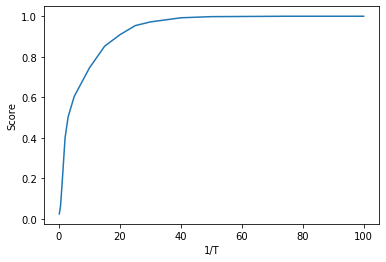

In [27]:
invs   = [1e-1, 5e-1, 1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 50, 75, 100]
scores = []

for inv_T in invs:
    score = evaluateC(v0, w, a, b, inv_T=inv_T, C=6, fname=fname, verbose=False)
    scores.append(score)
    print("Inverse temperature: ", inv_T, " --> Score: ", score)

plt.plot(invs, scores)
plt.xlabel("1/T")
plt.ylabel("Score")
plt.plot()

As expected, the machine is able to reach high scores but it needs a lower temperature compared to the situations with a lower number of cases. Moreover, there is the overflow warning meaning that for that value of $\frac{1}{T}$ the exponential value for the machine is almost near to the one obtained for $T=0$.

## 3.3. - Tests for $M\ge1$ <a class="anchor" id="Ex5.3.3."></a>
* [Index](#Ex5.i)

We try now to change the number of hidden units and check if there are significant variations in the performance.

In [28]:
from mpl_toolkits.mplot3d import Axes3D

ms   = [1, 2, 3, 4, 5]
invs = [5e-1, 1, 1.5, 2, 3, 5, 10, 15, 20, 30, 40 , 50]
C    = [4, 5, 6]

xs = []
ys = []
zs = []

for i,c in enumerate(C):
    x = []
    y = []
    z = []
    
    v0, v, fname = gen_data(C=c, verbose=False)
    
    for m in ms:
        w, a, b = train_RBM(v, max_epoch=20, inv_T=1, verbose=False, patience=20, M=m)
        for inv_T in invs:
            score =  evaluateC(v0, w, a, b, inv_T=inv_T, C=c, fname=fname, verbose=False)
            x.append(m)
            y.append(inv_T)
            z.append(score)
            print("C:", c, "M: ", m, "inv_T: ", inv_T, " --> Score: ", score)
    
    xs.append(x)
    ys.append(y)
    zs.append(z)

completed epoch 20 with l_rate = 0.20000000000000007
C: 4 M:  1 inv_T:  0.5  --> Score:  0.0382
C: 4 M:  1 inv_T:  1  --> Score:  0.0837
C: 4 M:  1 inv_T:  1.5  --> Score:  0.1071
C: 4 M:  1 inv_T:  2  --> Score:  0.1191
C: 4 M:  1 inv_T:  3  --> Score:  0.1249
C: 4 M:  1 inv_T:  5  --> Score:  0.1246
C: 4 M:  1 inv_T:  10  --> Score:  0.128
C: 4 M:  1 inv_T:  15  --> Score:  0.1371
C: 4 M:  1 inv_T:  20  --> Score:  0.1534
C: 4 M:  1 inv_T:  30  --> Score:  0.1723
C: 4 M:  1 inv_T:  40  --> Score:  0.196
C: 4 M:  1 inv_T:  50  --> Score:  0.2218
completed epoch 20 with l_rate = 0.20000000000000007
C: 4 M:  2 inv_T:  0.5  --> Score:  0.1016
C: 4 M:  2 inv_T:  1  --> Score:  0.4321
C: 4 M:  2 inv_T:  1.5  --> Score:  0.7542
C: 4 M:  2 inv_T:  2  --> Score:  0.902
C: 4 M:  2 inv_T:  3  --> Score:  0.9877
C: 4 M:  2 inv_T:  5  --> Score:  1.0
C: 4 M:  2 inv_T:  10  --> Score:  1.0
C: 4 M:  2 inv_T:  15  --> Score:  1.0
C: 4 M:  2 inv_T:  20  --> Score:  1.0
C: 4 M:  2 inv_T:  30  --> Scor

C: 6 M:  5 inv_T:  50  --> Score:  0.8921


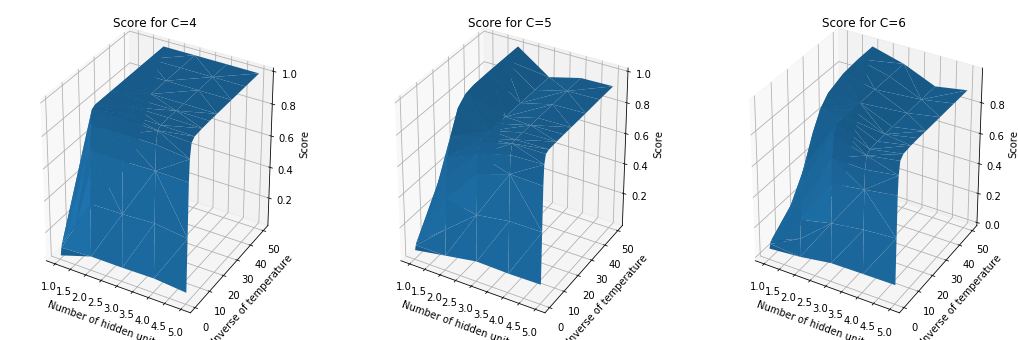

In [29]:
fig = plt.figure(figsize=(18, 6))

for i,c in enumerate(C):
    ax = fig.add_subplot(1,3,i+1, projection='3d')
    ax.plot_trisurf(xs[i],ys[i],zs[i])
    ax.set_xlabel("Number of hidden units")
    ax.set_ylabel("Inverse of temperature")
    ax.set_zlabel("Score")
    ax.set_title("Score for C="+str(c))

From the plots it is evident that there aren't many significant changes in the score, depending on the $\frac{1}{T}$ value, with respect to the case of $M=2$, with the expeption of the case of $M=1$ where the RBM doesn't work properly.
If we observe deeply the scores obtained in the previous cell, we can see that the best value for $M$ is $M=2$ since with this value we get the best results at higher temperatures in comparison to the others.

So, in the last point we will continue with $M=2$ fixed.

# 4. - Experiments <a class="anchor" id="Ex5.4."></a>
* [Index](#Ex5.i)

The possible variations we can now make are changing the lenght of each state (trought the ```Z``` parameter) and the ```q``` value which determines the error ratio, in particular we can see at which point the machine is not able to classify properly anymore, this can also be done for each of the previous situations regarding the number of cases. We will first start with $C=4$ and see how the scores change with regard to the other parameters.

## 4.1. - 4 cases ($C=4$) <a class="anchor" id="Ex5.4.1."></a>
* [Index](#Ex5.i)

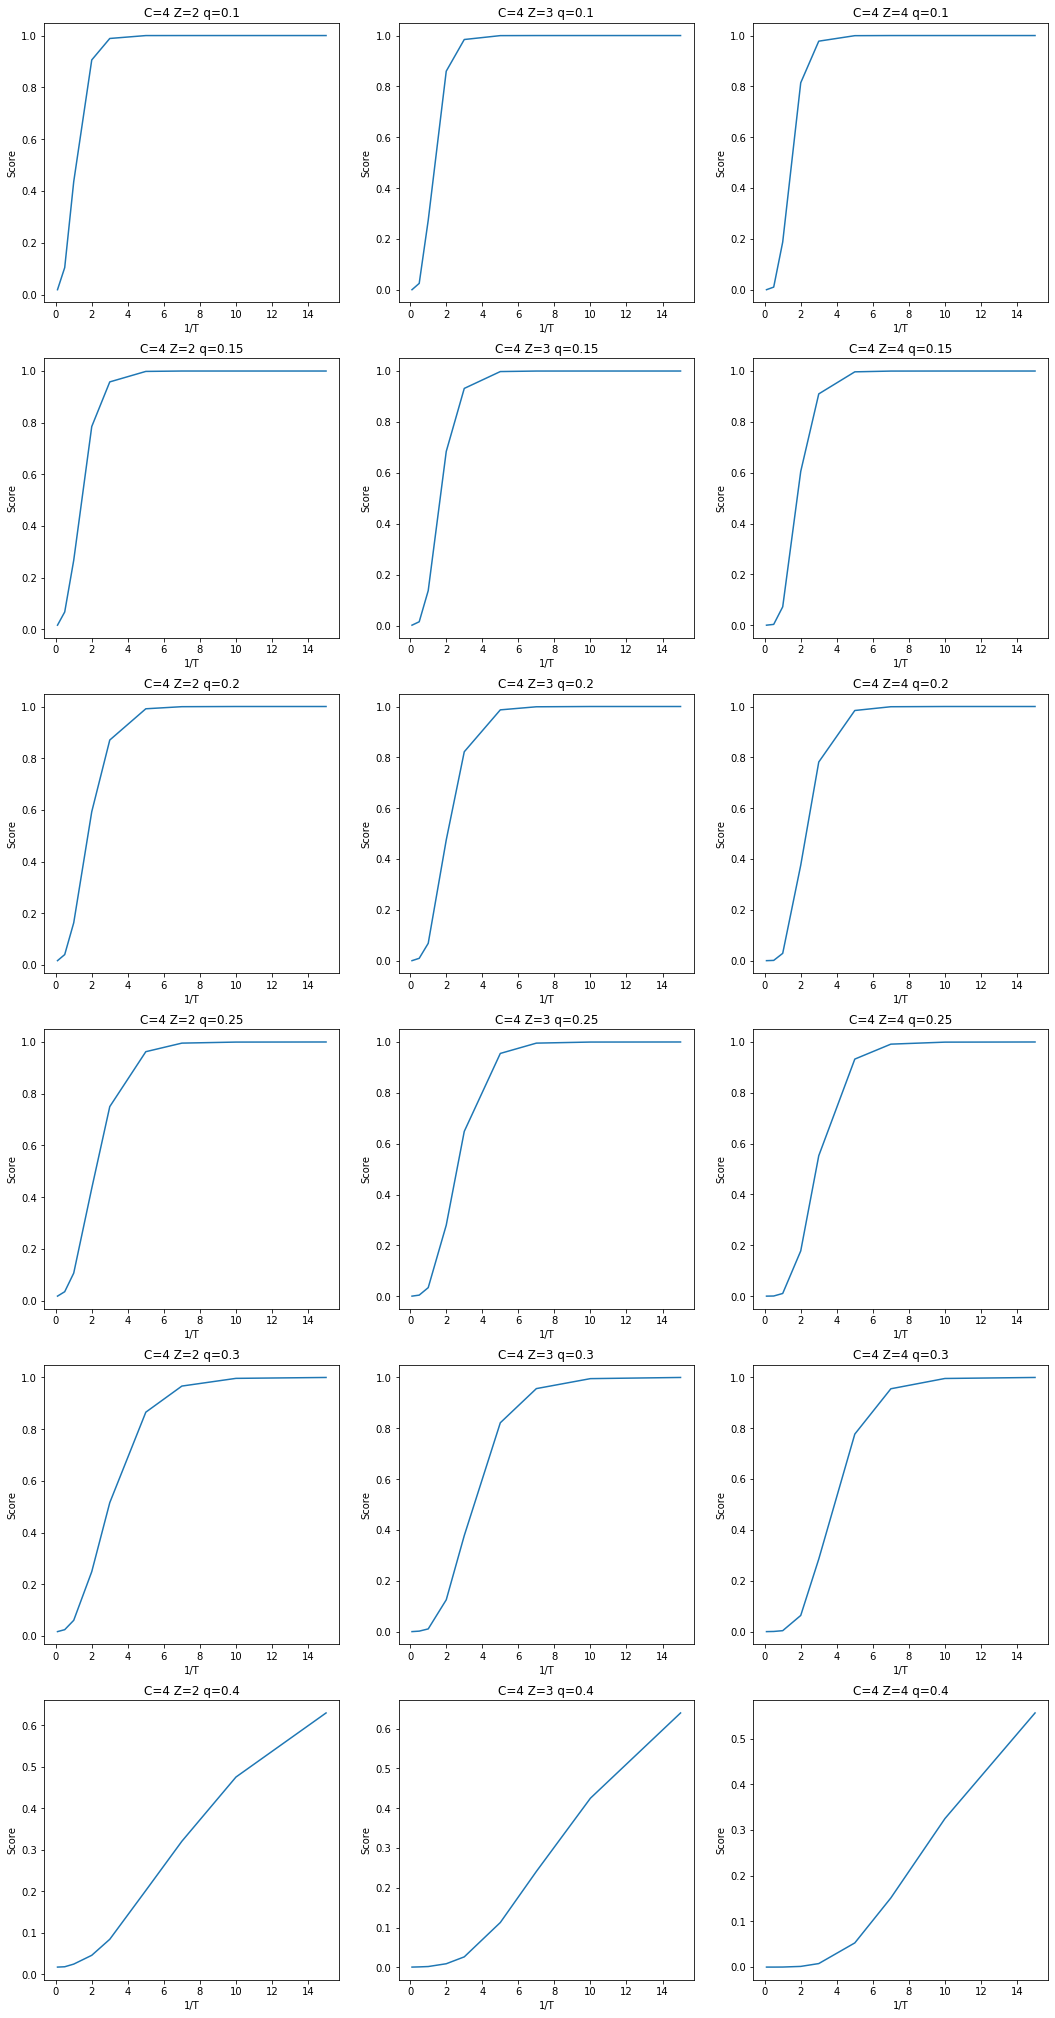

In [30]:
invs = [1e-1, 5e-1, 1, 2, 3, 5, 7, 10, 15]
Zs   = [2, 3, 4]
qs   = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]

fig, ax = plt.subplots(len(qs), len(Zs), figsize=(6*len(Zs), 6*len(qs)))

for i,q in enumerate(qs):
    for j,Z in enumerate(Zs):
        v0, v, fname = gen_data(C=4, Z=Z, q=q, verbose=False)
        w, a, b      = train_RBM(v, max_epoch=20, inv_T=1, verbose=False, grid=True)
        scores       = []
        
        for inv_T in invs:
            scores.append(evaluateC(v0, w, a, b, inv_T=inv_T, C=4, Z=Z, fname=fname, verbose=False))
        
        ax[i,j].plot(invs, scores)
        ax[i,j].set_xlabel("1/T")
        ax[i,j].set_ylabel("Score")
        ax[i,j].set_title("C=4 Z="+str(Z)+" q="+str(q))

## 4.2. - 5 cases ($C=5$) <a class="anchor" id="Ex5.4.2."></a>
* [Index](#Ex5.i)

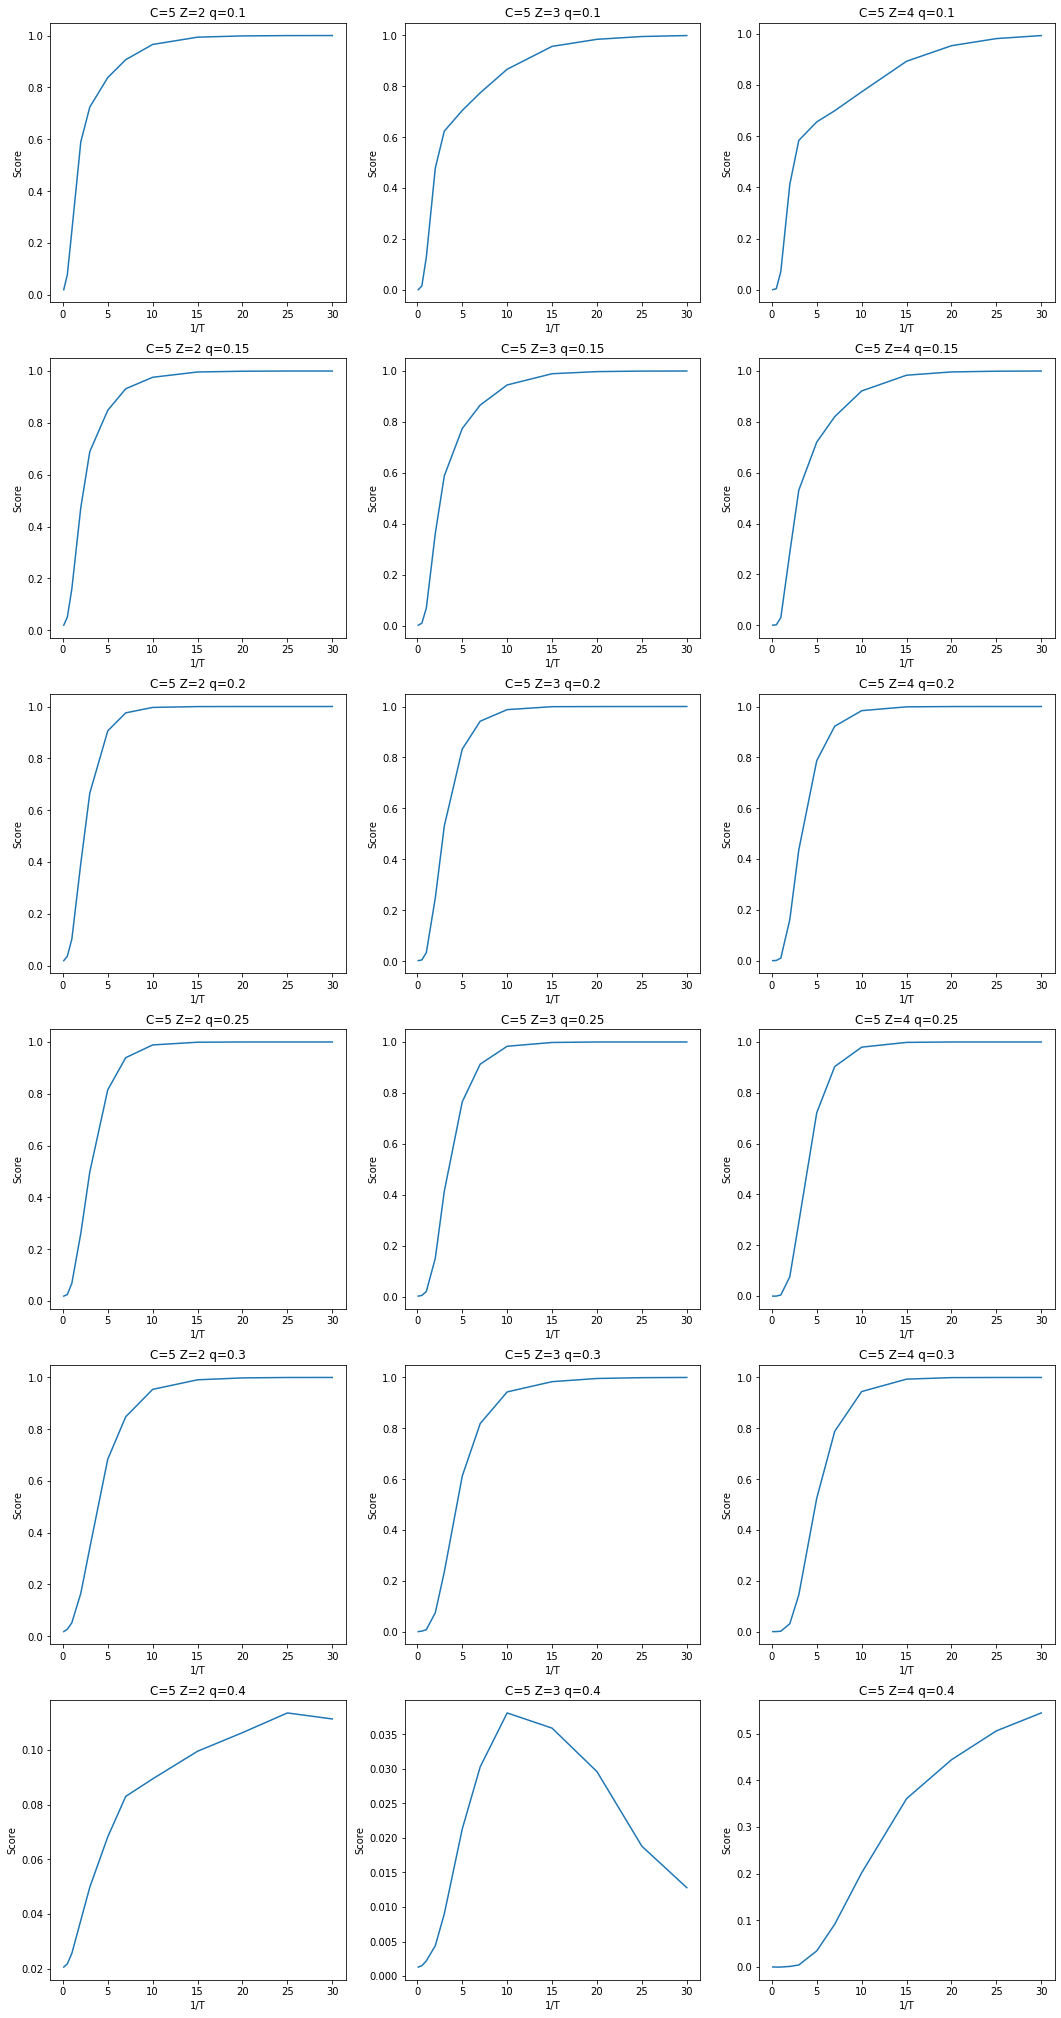

In [31]:
invs = [1e-1, 5e-1, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30]
Zs   = [2, 3, 4]
qs   = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]

fig, ax = plt.subplots(len(qs), len(Zs), figsize=(6*len(Zs), 6*len(qs)))

for i,q in enumerate(qs):
    for j,Z in enumerate(Zs):
        v0, v, fname = gen_data(C=5, Z=Z, q=q, verbose=False)
        w, a, b      = train_RBM(v, max_epoch=20, inv_T=1, verbose=False, grid=True)
        scores       = []
        
        for inv_T in invs:
            scores.append(evaluateC(v0, w, a, b, inv_T=inv_T, C=5, Z=Z, fname=fname, verbose=False))
        
        ax[i,j].plot(invs, scores)
        ax[i,j].set_xlabel("1/T")
        ax[i,j].set_ylabel("Score")
        ax[i,j].set_title("C=5 Z="+str(Z)+" q="+str(q))

## 4.3. - 6 cases ($C=6$) <a class="anchor" id="Ex5.4.3."></a>
* [Index](#Ex5.i)

/home/rocco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


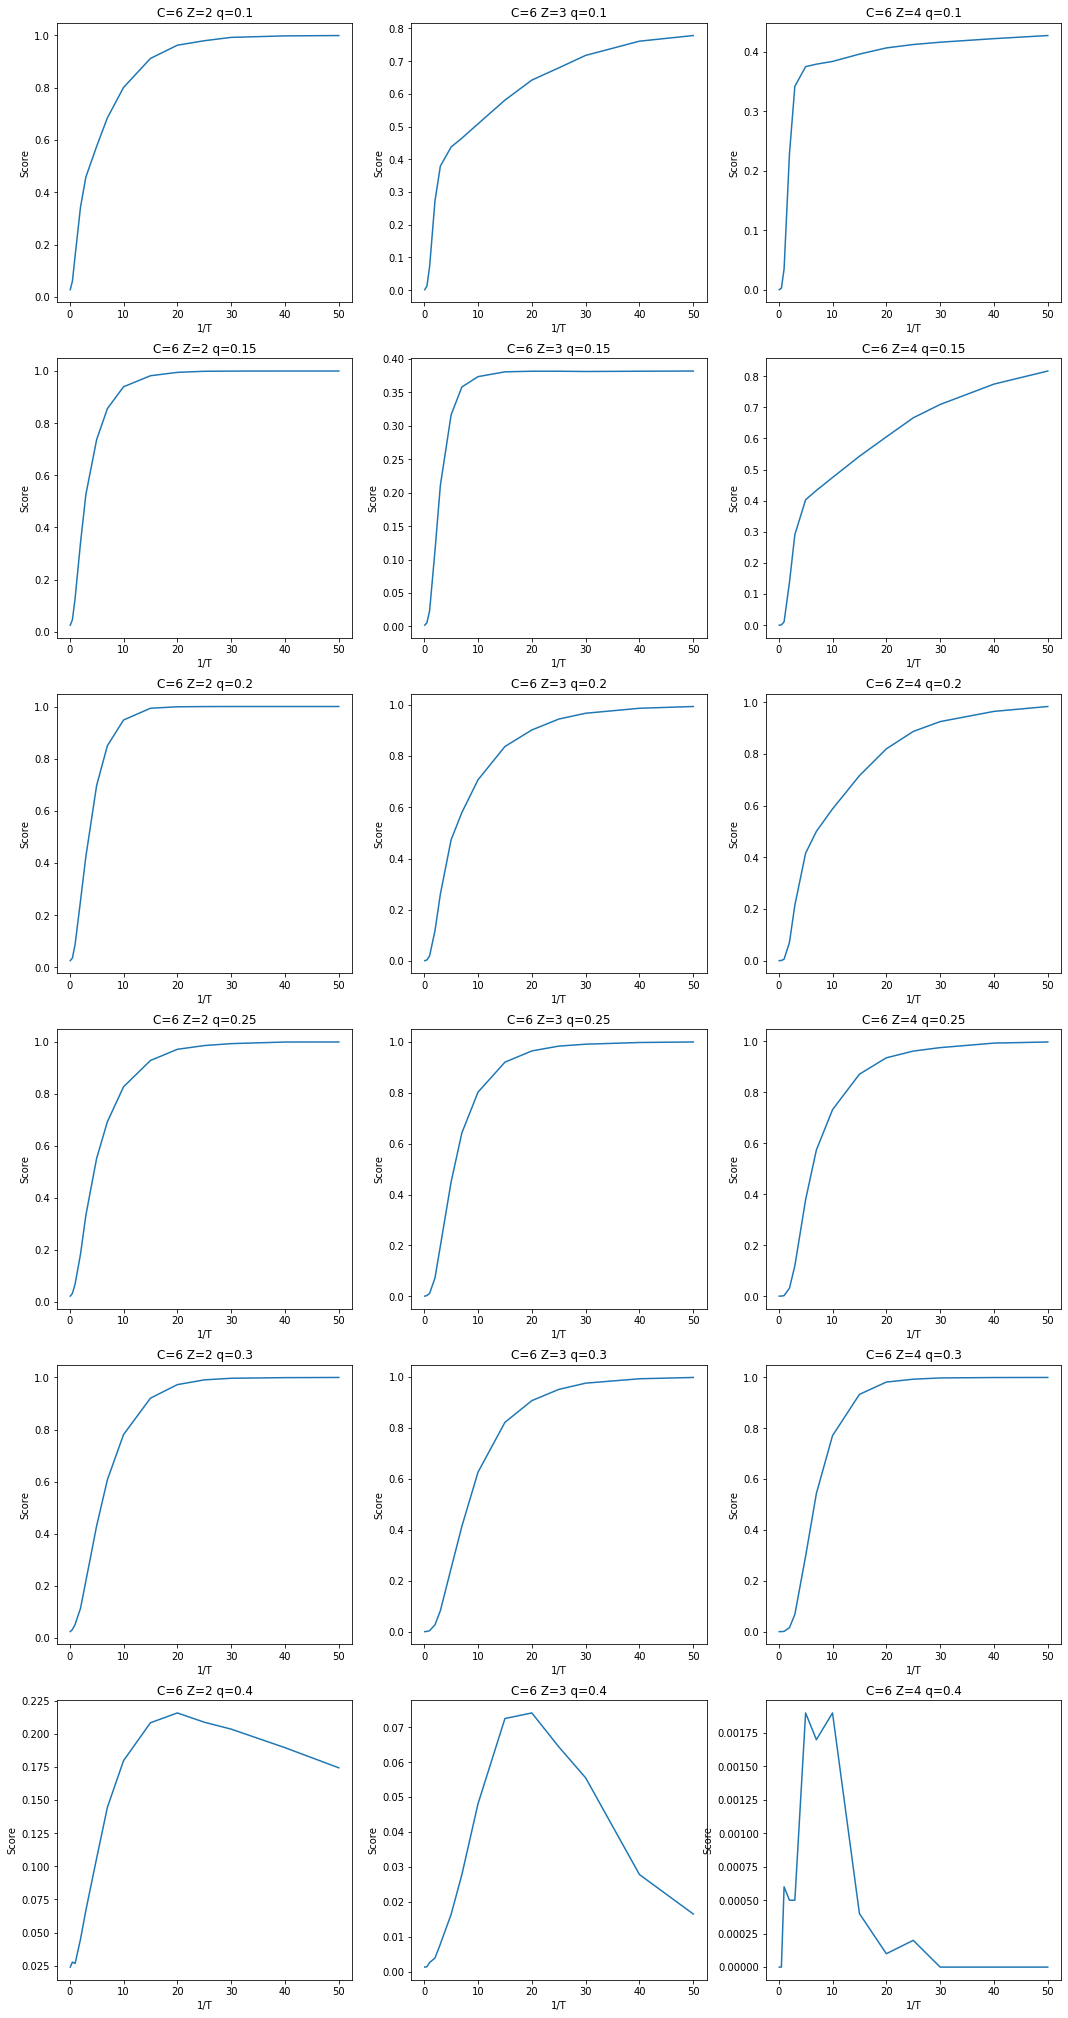

In [32]:
invs = [1e-1, 5e-1, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]
Zs   = [2, 3, 4]
qs   = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]

fig, ax = plt.subplots(len(qs), len(Zs), figsize=(6*len(Zs), 6*len(qs)))

for i,q in enumerate(qs):
    for j,Z in enumerate(Zs):
        v0, v, fname = gen_data(C=6, Z=Z, q=q, verbose=False)
        w, a, b      = train_RBM(v, max_epoch=20, inv_T=1, verbose=False, grid=True)
        scores       = []
        
        for inv_T in invs:
            scores.append(evaluateC(v0, w, a, b, inv_T=inv_T, C=6, Z=Z, fname=fname, verbose=False))
        
        ax[i,j].plot(invs, scores)
        ax[i,j].set_xlabel("1/T")
        ax[i,j].set_ylabel("Score")
        ax[i,j].set_title("C=6 Z="+str(Z)+" q="+str(q))